#### This code generates large dataframe containing multiple timeseries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

from sklearn import tree

from sklearn.metrics import roc_curve, auc
#from sklearn.preprocessing import LabelBinarizer

from pandas.tseries.offsets import *

import time


#from graphviz import Source

#### parameters to set

In [2]:
n_series = 6
start_date = '2017-08-01 00:00:00'
end_date = '2017-08-07 23:59:59'

# regular behaviour
max_noise_amplitude = 0.05 # all the timeseries will have values between 0 and 1

# anomalies
p_anomaly = 10E-6
max_anomaly_duration = 4*3600 # 4 h

# tuning parameters
cut = 0.55
window = 24

#### generate normal data

In [3]:
dti=pd.DatetimeIndex(start=start_date,end=end_date, freq='s')
n_timesteps = len(dti)
df = pd.DataFrame()
for s in range(n_series):
    v = np.random.normal(random.random()/2, max_noise_amplitude/random.randint(1, 8), n_timesteps) 
    df['link '+str(s)] = pd.Series(v)
df['Flag']=0
df['auc_score']=0.5
df.index = dti
df.head()

,link 0,link 1,link 2,link 3,link 4,link 5,Flag,auc_score
2017-08-01 00:00:00,0.468598,0.206171,0.094568,0.242586,0.513942,0.036391,0,0.5
2017-08-01 00:00:01,0.503519,0.216839,0.108965,0.208978,0.458141,0.024729,0,0.5
2017-08-01 00:00:02,0.406503,0.211887,0.101979,0.236703,0.482279,0.073109,0,0.5
2017-08-01 00:00:03,0.411114,0.208440,0.085352,0.227735,0.482240,0.111903,0,0.5
2017-08-01 00:00:04,0.534264,0.205985,0.092419,0.227306,0.514252,0.098121,0,0.5


#### generate anomalies

In [4]:
to_generate = int(n_timesteps * p_anomaly)
for a in range(to_generate):
    affects = random.sample(range(n_series), random.randint(1, n_series))
    duration = int(max_anomaly_duration * random.random())
    start = int(n_timesteps * random.random())
    end = min(start+duration, n_timesteps)
    print('affected:', affects, df.iloc[start].name, df.iloc[end].name)
    for s in affects:
        df.iloc[start:end,s] = df.iloc[start:end,s] + random.random() * 0.2
    df.iloc[start:end,n_series]=1
        

affected: [1, 0] 2017-08-06 23:41:37 2017-08-07 02:17:20
affected: [4, 3, 0, 5, 1] 2017-08-01 11:31:05 2017-08-01 13:52:15
affected: [1, 4, 3] 2017-08-05 17:23:37 2017-08-05 20:24:48
affected: [2, 4, 5, 0, 1, 3] 2017-08-05 01:00:13 2017-08-05 01:11:59
affected: [0] 2017-08-02 04:13:20 2017-08-02 07:23:20
affected: [1] 2017-08-02 01:46:25 2017-08-02 02:19:11


#### enforce range

In [5]:
df[df<0] = 0
df[df>1] = 1

#### plot timeseries

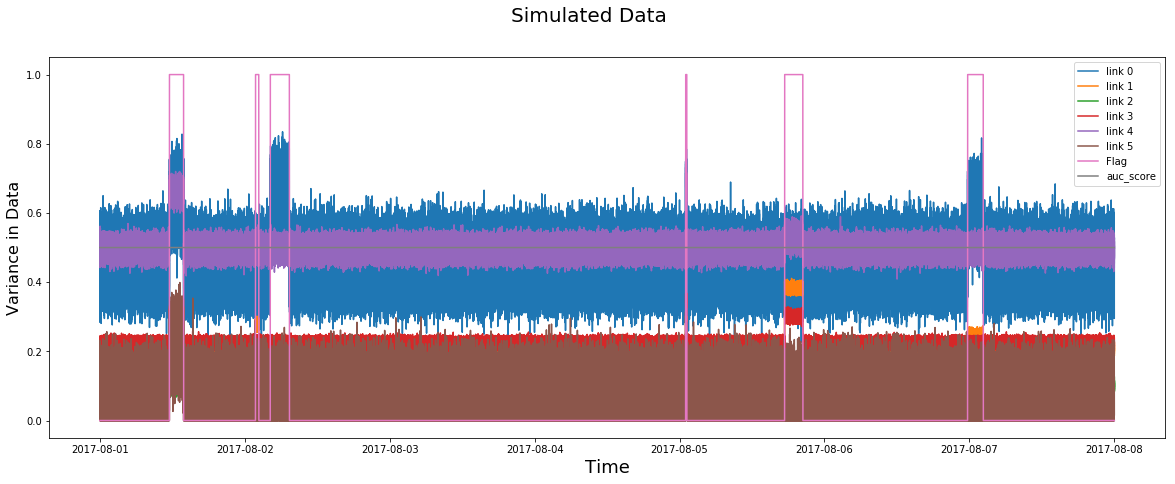

In [6]:
#df.plot(figsize=(20,7))
fig = plt.figure(figsize=(20,7))
plt.plot(df)
fig.suptitle('Simulated Data', fontsize=20)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Variance in Data', fontsize=16)
plt.legend(df)

In [7]:
#plt.figure(figsize=[16, 17])
#gs = gridspec.GridSpec(4, 1)

#ax2.plot(df)
#ax2.set_xlabel('time')
#ax2.set_ylabel('variance in data')
#ax2.legend()

#plt.show()

In [8]:
print(df['auc_score'])

2017-08-01 00:00:00    0.5
2017-08-01 00:00:01    0.5
2017-08-01 00:00:02    0.5
2017-08-01 00:00:03    0.5
2017-08-01 00:00:04    0.5
2017-08-01 00:00:05    0.5
2017-08-01 00:00:06    0.5
2017-08-01 00:00:07    0.5
2017-08-01 00:00:08    0.5
2017-08-01 00:00:09    0.5
2017-08-01 00:00:10    0.5
2017-08-01 00:00:11    0.5
2017-08-01 00:00:12    0.5
2017-08-01 00:00:13    0.5
2017-08-01 00:00:14    0.5
2017-08-01 00:00:15    0.5
2017-08-01 00:00:16    0.5
2017-08-01 00:00:17    0.5
2017-08-01 00:00:18    0.5
2017-08-01 00:00:19    0.5
2017-08-01 00:00:20    0.5
2017-08-01 00:00:21    0.5
2017-08-01 00:00:22    0.5
2017-08-01 00:00:23    0.5
2017-08-01 00:00:24    0.5
2017-08-01 00:00:25    0.5
2017-08-01 00:00:26    0.5
2017-08-01 00:00:27    0.5
2017-08-01 00:00:28    0.5
2017-08-01 00:00:29    0.5
                      ... 
2017-08-07 23:59:30    0.5
2017-08-07 23:59:31    0.5
2017-08-07 23:59:32    0.5
2017-08-07 23:59:33    0.5
2017-08-07 23:59:34    0.5
2017-08-07 23:59:35    0.5
2

In [9]:
print(df)

                       link 0    link 1    link 2    link 3    link 4  \
2017-08-01 00:00:00  0.468598  0.206171  0.094568  0.242586  0.513942   
2017-08-01 00:00:01  0.503519  0.216839  0.108965  0.208978  0.458141   
2017-08-01 00:00:02  0.406503  0.211887  0.101979  0.236703  0.482279   
2017-08-01 00:00:03  0.411114  0.208440  0.085352  0.227735  0.482240   
2017-08-01 00:00:04  0.534264  0.205985  0.092419  0.227306  0.514252   
2017-08-01 00:00:05  0.375699  0.210646  0.103656  0.219634  0.492604   
2017-08-01 00:00:06  0.428051  0.214570  0.098800  0.225240  0.491520   
2017-08-01 00:00:07  0.455797  0.206883  0.114284  0.210852  0.500613   
2017-08-01 00:00:08  0.407935  0.204107  0.113339  0.216508  0.516090   
2017-08-01 00:00:09  0.431232  0.209003  0.116939  0.222846  0.513983   
2017-08-01 00:00:10  0.530151  0.217544  0.097011  0.211609  0.469333   
2017-08-01 00:00:11  0.473623  0.207979  0.101500  0.221321  0.516031   
2017-08-01 00:00:12  0.478717  0.207141  0.119684  

#### functions

In [10]:
def check_for_anomaly(ref, sub):
    
    y_ref = pd.Series([0] * ref.shape[0])
    X_ref = ref
    #print("y_ref before: ", y_ref)
    #print("x_ref before: ", x_ref)
    del X_ref['Flag']
    del X_ref['auc_score']
    #print("x_ref after: ", X_ref)
    
    y_sub = pd.Series([1] * sub.shape[0])
    X_sub=sub
    #print("y_sub before: ", y_sub)
    #print("x_sub before: ", X_sub)
    del X_sub['Flag']
    del X_sub['auc_score']
    #print("X_sub after: ", X_sub)
    
    # separate Reference and Subject into Train and Test
    X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size=0.3, random_state=42)
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
    
    # combine training ref and sub samples
    X_train = pd.concat([X_ref_train, X_sub_train])
    y_train = pd.concat([y_ref_train, y_sub_train])

    # combine testing ref and sub samples
    X_test = pd.concat([X_ref_test, X_sub_test])
    y_test = pd.concat([y_ref_test, y_sub_test])
    
#     dtc=DecisionTreeClassifier()
    clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1)) #dtc
#     clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm="SAMME",n_estimators=200)
    
    #train an AdaBoost model to be able to tell the difference between the reference and subject data
    clf.fit(X_train, y_train) 

    #Predict using the combined test data
    y_predict = clf.predict(X_test)
    
    # scores = cross_val_score(clf, X, y)
    # print(scores)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_predict) # calculate the false positive rate and true positive rate
    auc_score = auc(fpr, tpr) #calculate the AUC score
    print ("auc_score = ", auc_score, "\tfeature importances:", clf.feature_importances_)
    
    if auc_score > cut: 
        plot_roc(fpr, tpr, auc_score)
        #filename='tree_'+sub.index.min().strftime("%Y-%m-%d_%H")
        #tree.export_graphviz(clf.estimators_[0] , out_file=filename +'_1.dot') 
        #tree.export_graphviz(clf.estimators_[1] , out_file=filename +'_2.dot') 
        
    return auc_score

In [11]:
def plot_roc(fpr,tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], linestyle='--', color='r',label='Luck', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [12]:
start = df.index.min()
end = df.index.max()

#print(df)

print(df.index)

DatetimeIndex(['2017-08-01 00:00:00', '2017-08-01 00:00:01',
               '2017-08-01 00:00:02', '2017-08-01 00:00:03',
               '2017-08-01 00:00:04', '2017-08-01 00:00:05',
               '2017-08-01 00:00:06', '2017-08-01 00:00:07',
               '2017-08-01 00:00:08', '2017-08-01 00:00:09',
               ...
               '2017-08-07 23:59:50', '2017-08-07 23:59:51',
               '2017-08-07 23:59:52', '2017-08-07 23:59:53',
               '2017-08-07 23:59:54', '2017-08-07 23:59:55',
               '2017-08-07 23:59:56', '2017-08-07 23:59:57',
               '2017-08-07 23:59:58', '2017-08-07 23:59:59'],
              dtype='datetime64[ns]', length=604800, freq='S')


#### Looping over time intervals

auc_score =  0.5 	feature importances: [ 0.22  0.2   0.16  0.12  0.22  0.08]
auc_score =  0.610628858025 	feature importances: [ 0.1   0.34  0.16  0.12  0.16  0.12]


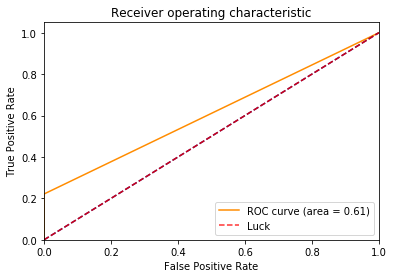

auc_score =  0.664949845679 	feature importances: [ 0.18  0.2   0.2   0.14  0.14  0.14]


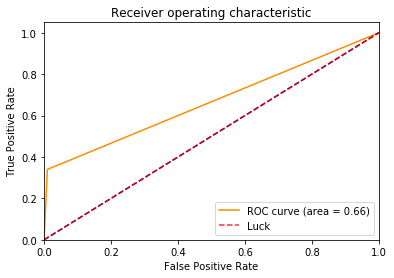

auc_score =  0.5 	feature importances: [ 0.26  0.18  0.18  0.14  0.16  0.08]
auc_score =  0.823707561728 	feature importances: [ 0.44  0.16  0.06  0.04  0.16  0.14]


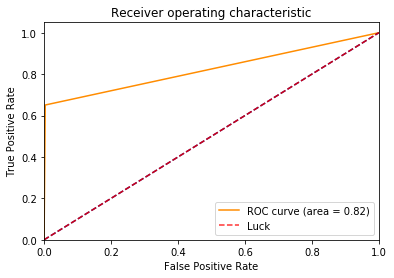

auc_score =  0.826253858025 	feature importances: [ 0.68  0.04  0.1   0.04  0.06  0.08]


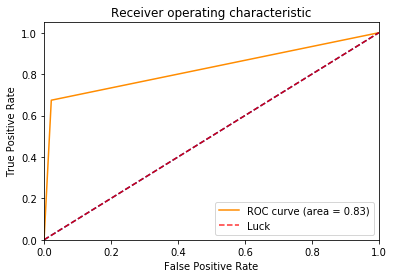

auc_score =  0.501601080247 	feature importances: [ 0.82  0.04  0.06  0.02  0.02  0.04]
auc_score =  0.5 	feature importances: [ 0.26  0.16  0.22  0.1   0.18  0.08]
auc_score =  0.499980709877 	feature importances: [ 0.46  0.12  0.16  0.1   0.12  0.04]
auc_score =  0.5 	feature importances: [ 0.34  0.2   0.14  0.12  0.12  0.08]
auc_score =  0.499980709877 	feature importances: [ 0.4   0.16  0.14  0.16  0.02  0.12]
auc_score =  0.5 	feature importances: [ 0.36  0.16  0.12  0.08  0.14  0.14]
auc_score =  0.5 	feature importances: [ 0.28  0.3   0.08  0.14  0.1   0.1 ]
auc_score =  0.5 	feature importances: [ 0.4   0.14  0.16  0.18  0.08  0.04]
auc_score =  0.499980709877 	feature importances: [ 0.4   0.06  0.1   0.1   0.22  0.12]
auc_score =  0.499980709877 	feature importances: [ 0.32  0.22  0.04  0.14  0.12  0.16]
auc_score =  0.5 	feature importances: [ 0.3   0.2   0.12  0.16  0.16  0.06]
auc_score =  0.5 	feature importances: [ 0.26  0.16  0.06  0.16  0.16  0.2 ]
auc_score =  0.5 	fea

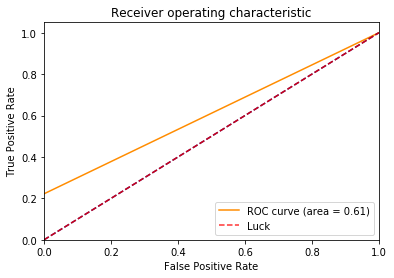

auc_score =  0.499961419753 	feature importances: [ 0.22  0.16  0.24  0.18  0.1   0.1 ]
auc_score =  0.499922839506 	feature importances: [ 0.12  0.32  0.18  0.16  0.12  0.1 ]
auc_score =  0.5 	feature importances: [ 0.14  0.28  0.18  0.1   0.22  0.08]
auc_score =  0.499980709877 	feature importances: [ 0.18  0.26  0.28  0.1   0.1   0.08]
auc_score =  0.5 	feature importances: [ 0.2   0.22  0.1   0.26  0.12  0.1 ]
auc_score =  0.499922839506 	feature importances: [ 0.2   0.16  0.18  0.08  0.18  0.2 ]
auc_score =  0.5 	feature importances: [ 0.22  0.24  0.1   0.16  0.16  0.12]
auc_score =  0.5 	feature importances: [ 0.12  0.14  0.3   0.24  0.14  0.06]
auc_score =  0.5 	feature importances: [ 0.16  0.36  0.2   0.06  0.1   0.12]
auc_score =  0.5 	feature importances: [ 0.14  0.24  0.14  0.16  0.2   0.12]
auc_score =  0.5 	feature importances: [ 0.06  0.14  0.2   0.16  0.3   0.14]
auc_score =  0.499980709877 	feature importances: [ 0.14  0.26  0.16  0.2   0.18  0.06]
auc_score =  0.5 	fea

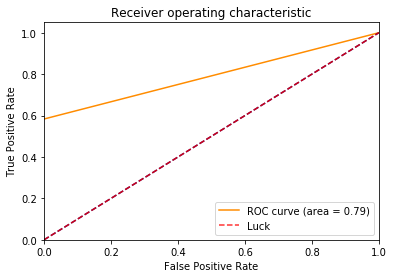

auc_score =  0.964737654321 	feature importances: [ 0.22  0.24  0.06  0.1   0.28  0.1 ]


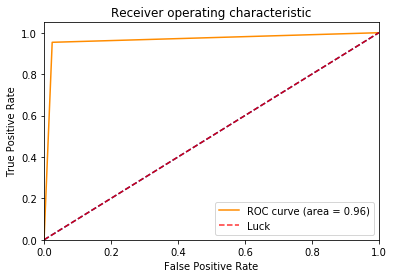

auc_score =  0.507291666667 	feature importances: [ 0.1   0.12  0.12  0.24  0.24  0.18]
auc_score =  0.499980709877 	feature importances: [ 0.14  0.2   0.08  0.2   0.26  0.12]
auc_score =  0.5 	feature importances: [ 0.12  0.18  0.16  0.18  0.1   0.26]
auc_score =  0.499980709877 	feature importances: [ 0.16  0.12  0.18  0.2   0.12  0.22]
auc_score =  0.499980709877 	feature importances: [ 0.04  0.22  0.34  0.24  0.04  0.12]
auc_score =  0.5 	feature importances: [ 0.16  0.26  0.12  0.2   0.16  0.1 ]
auc_score =  0.5 	feature importances: [ 0.26  0.06  0.16  0.16  0.24  0.12]
auc_score =  0.5 	feature importances: [ 0.1   0.24  0.14  0.22  0.16  0.14]
auc_score =  0.500424382716 	feature importances: [ 0.2   0.22  0.12  0.12  0.28  0.06]
auc_score =  0.5 	feature importances: [ 0.2   0.14  0.18  0.2   0.2   0.08]
auc_score =  0.499961419753 	feature importances: [ 0.2   0.08  0.24  0.26  0.16  0.06]
auc_score =  0.5 	feature importances: [ 0.12  0.16  0.24  0.16  0.2   0.12]
auc_score 

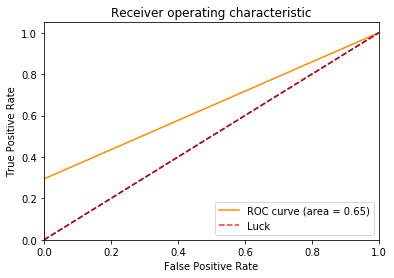

auc_score =  0.976099537037 	feature importances: [ 0.22  0.4   0.1   0.12  0.06  0.1 ]


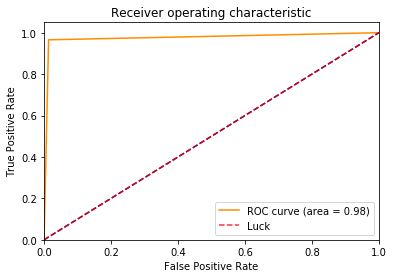

auc_score =  0.533198302469 	feature importances: [ 0.24  0.36  0.12  0.08  0.06  0.14]
auc_score =  0.499961419753 	feature importances: [ 0.14  0.1   0.36  0.2   0.06  0.14]
auc_score =  0.499903549383 	feature importances: [ 0.16  0.18  0.1   0.2   0.22  0.14]
auc_score =  0.5 	feature importances: [ 0.14  0.24  0.14  0.16  0.16  0.16]
auc_score =  0.49994212963 	feature importances: [ 0.26  0.2   0.12  0.08  0.28  0.06]
auc_score =  0.49994212963 	feature importances: [ 0.1   0.22  0.16  0.16  0.2   0.16]
auc_score =  0.500405092593 	feature importances: [ 0.22  0.2   0.16  0.12  0.2   0.1 ]
auc_score =  0.499980709877 	feature importances: [ 0.14  0.24  0.06  0.2   0.22  0.14]
auc_score =  0.500424382716 	feature importances: [ 0.2   0.2   0.22  0.2   0.1   0.08]
auc_score =  0.499980709877 	feature importances: [ 0.18  0.1   0.12  0.32  0.18  0.1 ]
auc_score =  0.500405092593 	feature importances: [ 0.14  0.16  0.16  0.26  0.2   0.08]
auc_score =  0.499980709877 	feature importan

In [13]:
start_time = time.time()

#find min and max timestamps

start = df.index.min()
end = df.index.max()

#round start 
start.seconds=0
start.minutes=0

ref = window * Hour()
sub = 1 * Hour()

# loop over them
ti=start+ref+sub
count=0
while ti < end + 1 * Minute():
    ref_start = ti-ref-sub
    ref_end = ti-sub
    ref_df = df[(df.index >= ref_start) & (df.index < ref_end)]
    #print("In while loop: ref_df: ", ref_df)
    sub_df = df[(df.index >= ref_end) & (df.index < ti)]
    #print("In while loop: sub_df: ", sub_df)
    auc_score = check_for_anomaly(ref_df, sub_df)
    df.loc[(df.index>=ref_end) & (df.index<=ti),['auc_score']] = auc_score
    #print(ti,"\trefes:" , ref_df.shape[0], "\tsubjects:", sub_df.shape[0], '\tauc:', auc_score)
    ti = ti + sub
    count=count+1
    #if count>2: break
    


In [14]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 580.288907289505 seconds ---


In [15]:
print(start)
print(end)

2017-08-01 00:00:00
2017-08-07 23:59:59


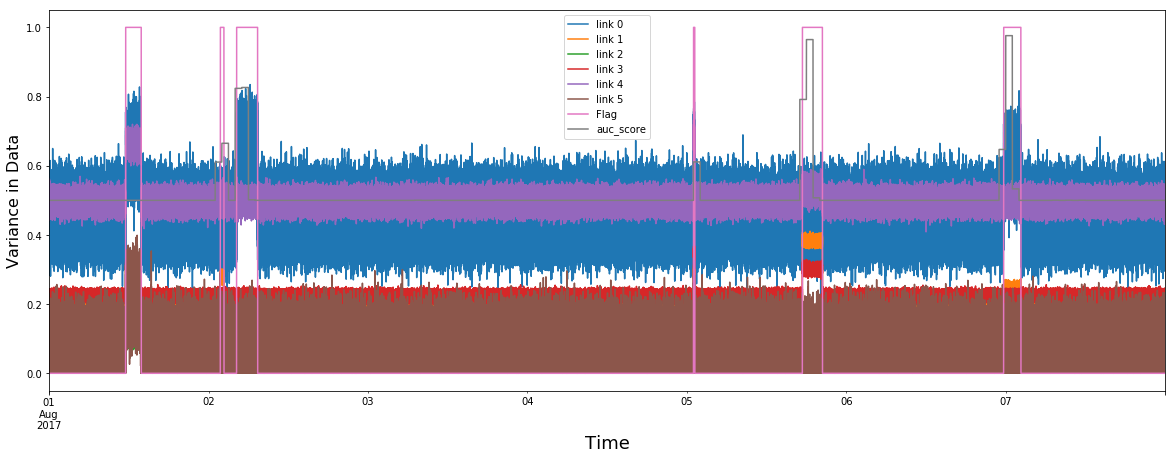

In [16]:
#df.plot(figsize=(20,7))

df.plot(figsize=(20,7))
plt.xlabel('Time', fontsize=18)
plt.ylabel('Variance in Data', fontsize=16)
plt.legend(df)

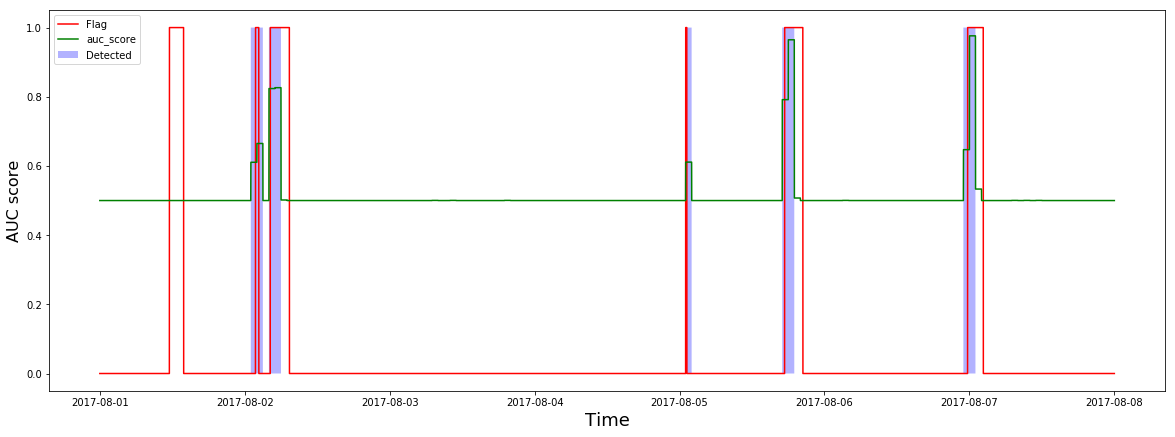

In [17]:
fig, ax = plt.subplots(figsize=(20,7))
df.loc[:,'Detected'] = 0
df.loc[df.auc_score>0.55,'Detected']=1
df.head()
ax.plot(df.Flag, 'r')
ax.plot(df.auc_score,'g')
ax.fill( df.Detected, 'b', alpha=0.3)
ax.legend(loc='upper left')
plt.xlabel('Time', fontsize=18)
plt.ylabel('AUC score', fontsize=16)
plt.show()